# Ndege Zetu Data Analysis

This notebook presents and analysis of audio recording annotations, point counts and citizen science data from two sites within the Mt Kenya ecosystem namely the Dedan Kimathi University Wildlife Conservancy (DeKUWC) and the Mt Kenya National Park (MKNP). The audio recordings were annotated by expert ornithologists.

This notebook aims to ensure reproducability of results reported in ``Comparing point counts, passive acoustic monitoring, citizen science and machine learning for bird species monitoring in the Mt Kenya ecosystem''  submitted to Philosophical Transactions of the Royal Society B.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import scipy 

from scipy import stats

import matplotlib.pyplot as plt

In [2]:
# set the seed for reproducability
np.random.seed(1234)
random.seed(1234)

In [3]:
def species_from_df(df):
    '''
    This function extracts species from the audio annotation files
    '''
    sps = []
    for i in range(len(df)):
        if not pd.isna(df.iloc[i]['Foreground Species']):
            sps += df.iloc[i]['Foreground Species'].split(';')
        if not pd.isna(df.iloc[i]['Background Species']):
            sps += df.iloc[i]['Background Species'].split(';')
    return list(set(sps))


In [4]:
# scientific names
df_sp = pd.read_csv('../annotations/Kenya-Species-List.csv')
# common name
kenyan_sp_cn = list(df_sp['Common Name'])
# scientific name
kenyan_sp_sn = list(df_sp['Scientific Name'])

# MKNP
We obtain the MKNP data for comparison of the three methods namely point counts (PC), autonomous recording units (ARU) and citizen science (Kenya Bird Map (KBM)). We determine relative abundance and use this for statistical comparison.

In [5]:
# MKNP PC Data
mknp_pc = pd.read_csv('../annotations/mknp-pc-2017-2018.csv')
mknp_pc_species = list(mknp_pc['Unnamed: 0'])
mknp_pc_mtx = mknp_pc[mknp_pc.keys()[1:]].to_numpy()
# frequency of occurence (foo) 
foo_pc = np.mean(mknp_pc_mtx, axis = 1)

In [6]:
# MKNP KBM Data
mknp_kbm = pd.read_csv('../annotations/mknp-kbm.csv')
mknp_kbm_species = list(mknp_kbm['Unnamed: 0'])
mknp_kbm_mtx = mknp_kbm[mknp_kbm.keys()[1:]].to_numpy()
# frequency of occurence (foo) 
foo_kbm = np.mean(mknp_kbm_mtx, axis = 1)


In [7]:
# MKNP KBM Data
# get all species
mknp_aru = pd.read_csv('../annotations/mknp-aru-2017-2018.csv')
mknp_aru_species = species_from_df(mknp_aru)

In [8]:
all_mknp_species = list(set(mknp_pc_species + mknp_aru_species + mknp_kbm_species))
all_mknp_species.sort()

## MKNP Species Richness
We obtain the species richness. These data are in Table 2 of the paper.

In [9]:
print('MKNP Species Richness: PC {}, ARU {}, KBM {} Total {}'.format(len(mknp_pc_species),
                                                                  len(mknp_aru_species),
                                                                  len(mknp_kbm_species),
                                                                  len(all_mknp_species)))

MKNP Species Richness: PC 48, ARU 35, KBM 125 Total 144


In [10]:
all_mknp_species_sn = [kenyan_sp_sn[kenyan_sp_cn.index(sp)] for indx, sp in enumerate(all_mknp_species)]

## Comparison of relative abundace

We use frequency of occurence to compare the relative abundance of species reported in the study by various methods. To compare PC and ARU, we simulate equal effort by sampling 10 recordings and treating them as equivalent to one point count.

In [11]:
# generate random PC
num_simulated_pc = 60
recordings_per_pc = 10 # similate 10 minute point count
aru_sim_pc = np.zeros((len(all_mknp_species), num_simulated_pc))

In [12]:
for i in range(num_simulated_pc):
    pc_df = mknp_aru.iloc[random.sample(range(len(mknp_aru)), recordings_per_pc)]
    pc_sps = species_from_df(pc_df)

    for pc_sp in pc_sps:
        aru_sim_pc[all_mknp_species.index(pc_sp), i] += 1
        

In [13]:
foo_aru_mknp = np.mean(aru_sim_pc, axis=1)
foo_pc_mknp = np.zeros(len(all_mknp_species))
foo_kbm_mknp = np.zeros(len(all_mknp_species))

In [14]:
for indx, sp in enumerate(mknp_pc_species):
    foo_pc_mknp[all_mknp_species.index(sp)] = foo_pc[indx]

for indx, sp in enumerate(mknp_kbm_species):
    foo_kbm_mknp[all_mknp_species.index(sp)] = foo_kbm[indx]

### Table 7 

The table below shows the frequency of occurence for the top 20 species according to PC for MKNP. It is Table 7 in the paper

In [15]:
mknp_df = pd.DataFrame(zip(all_mknp_species_sn, all_mknp_species, foo_pc_mknp, foo_aru_mknp, foo_kbm_mknp), columns=['Scientific Name','Common Name', 'Point Count', 'ARU', 'KBM'])
mknp_top = mknp_df.sort_values(by=['Point Count'], ascending=False)[:20]
#print(mknp_top.to_latex(index=False,
#                  formatters={"name": str.upper},
#                  float_format="{:.2f}".format,
#)) 
mknp_top

,Scientific Name,Common Name,Point Count,ARU,KBM
30,Phylloscopus umbrovirens,Brown Woodland Warbler,0.650000,1.000000,0.416667
38,Apalis porphyrolaema,Chestnut-throated Apalis,0.533333,0.866667,0.666667
76,Zosterops poliogastrus,Montane White-eye,0.500000,0.416667,0.000000
40,Bradypterus cinnamomeus,Cinnamon Bracken Warbler,0.450000,0.566667,0.583333
136,Pogonocichla stellata,White-starred Robin,0.366667,0.550000,0.500000
100,Poicephalus gulielmi,Red-fronted Parrot,0.283333,0.650000,0.583333
66,Tauraco hartlaubi,Hartlaub's Turaco,0.266667,0.300000,0.833333
82,Chloropeta similis,Mountain Yellow Warbler,0.233333,0.700000,0.416667
87,Cyanomitra olivacea,Olive Sunbird,0.133333,0.116667,0.250000
23,Psalidoprocne pristoptera,Black Saw-wing,0.116667,0.000000,0.000000


### Statistical Tests

In [16]:
# pc vs aru
mknp_pc_aru_species = list(set(mknp_pc_species + mknp_aru_species))
index_of_interest = [sp in mknp_pc_aru_species for sp in all_mknp_species]


Text(0.5, 1.0, 'MKNP')

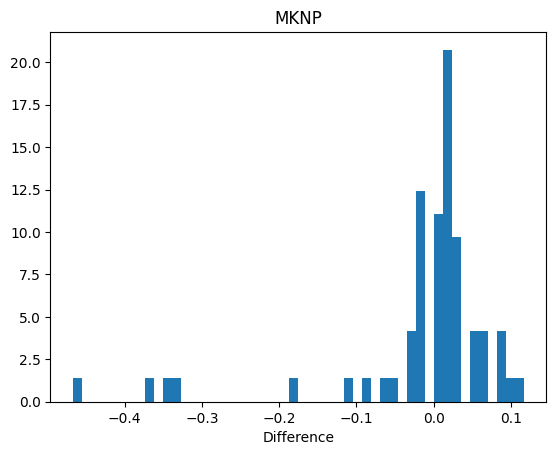

In [17]:
plt.hist(foo_pc_mknp[index_of_interest] - foo_aru_mknp[index_of_interest], 50, density=True);
plt.xlabel("Difference")
plt.title("MKNP")

In [18]:
stats.kstest(foo_pc_mknp[index_of_interest] - foo_aru_mknp[index_of_interest],
             stats.norm.cdf)

KstestResult(statistic=0.4535621029950777, pvalue=3.5999369814371817e-12, statistic_location=0.11666666666666667, statistic_sign=1)

In [19]:
sum(index_of_interest)

62

In [20]:
scipy.stats.wilcoxon(foo_pc_mknp[index_of_interest], foo_aru_mknp[index_of_interest])

WilcoxonResult(statistic=626.0, pvalue=0.31248714205192574)

In [21]:
# pc vs kbm
mknp_pc_kbm_species = list(set(mknp_pc_species + mknp_kbm_species))
index_of_interest = [sp in mknp_pc_kbm_species for sp in all_mknp_species]

stats.kstest(foo_pc_mknp[index_of_interest] - foo_kbm_mknp[index_of_interest],
             stats.norm.cdf)

KstestResult(statistic=0.4512842157443613, pvalue=2.3113066349577328e-26, statistic_location=0.05, statistic_sign=1)

In [22]:
scipy.stats.wilcoxon(foo_pc_mknp[index_of_interest], foo_kbm_mknp[index_of_interest])

WilcoxonResult(statistic=442.0, pvalue=1.0007099824756123e-20)

In [23]:
sum(index_of_interest)

139

In [24]:
# aru vs kbm
mknp_aru_kbm_species = list(set(mknp_aru_species + mknp_kbm_species))
index_of_interest = [sp in mknp_aru_kbm_species for sp in all_mknp_species]

stats.kstest(foo_aru_mknp[index_of_interest] - foo_kbm_mknp[index_of_interest],
             stats.norm.cdf)

KstestResult(statistic=0.4435727894309782, pvalue=1.5246989520686471e-24, statistic_location=0.06666666666666667, statistic_sign=1)

In [25]:
scipy.stats.wilcoxon(foo_aru_mknp[index_of_interest], foo_kbm_mknp[index_of_interest])

WilcoxonResult(statistic=476.5, pvalue=3.9394553182305737e-19)

In [26]:
sum(index_of_interest)

134

# DeKUWC

In [27]:
dekuwc_pc = pd.read_csv('../annotations/dekuwc-pc-2017.csv')
dekuwc_pc_mtx = dekuwc_pc[dekuwc_pc.keys()[1:]].to_numpy()
foo_pc = np.mean(dekuwc_pc_mtx, axis = 1)

In [28]:
pfiles = os.listdir('../annotations/')
# audio 
dekuwc_aru_species = []
for pfile in pfiles:
    if 'pc' not in pfile and 'kbm' not in pfile and 'dekuwc' in pfile and pfile.endswith('csv'):
        df = pd.read_csv(os.path.join('../annotations', pfile))
        dekuwc_aru_species += species_from_df(df)

dekuwc_aru_species = list(set(dekuwc_aru_species))
dekuwc_aru_species.sort()

In [29]:
dekuwc_pc_species = list(dekuwc_pc['Unnamed: 0'])
dekuwc_kbm = pd.read_csv('../annotations/dekuwc-kbm.csv')
dekuwc_kbm_species = list(dekuwc_kbm['Unnamed: 0'])

dekuwc_kbm_mtx = dekuwc_kbm[dekuwc_kbm.keys()[1:]].to_numpy()
# frequency of occurence (foo) 
foo_kbm = np.mean(dekuwc_kbm_mtx, axis = 1)

In [30]:
all_dekuwc_species =  list(set(dekuwc_aru_species + dekuwc_pc_species + dekuwc_kbm_species))
all_dekuwc_species.sort()

## DeKUWC Species Richness

The species richness for DeKUWC is shown below. The data appear in Table 2 of the paper

In [31]:
print('DeKUWC Species Richness: PC {}, ARU {}, KBM {} Total {}'.format(len(dekuwc_pc_species),
                                                                  len(dekuwc_aru_species),
                                                                  len(dekuwc_kbm_species),
                                                                  len(all_dekuwc_species)))

DeKUWC Species Richness: PC 57, ARU 89, KBM 224 Total 260


In [32]:
all_dekuwc_species_sn = [kenyan_sp_sn[kenyan_sp_cn.index(sp)] for indx, sp in enumerate(all_dekuwc_species)]

In [33]:
# generate random PC
num_simulated_pc = 40
recordings_per_pc = 10 # similate 10 minute point count
aru_sim_pc = np.zeros((len(all_dekuwc_species), num_simulated_pc))

In [34]:
dekuwc_aru_files = [pfile for pfile in pfiles if 'pc' not in pfile and 'kbm' not in pfile and 'dekuwc' in pfile and pfile.endswith('csv')]

In [35]:
for i in range(num_simulated_pc):
    dekuwc_aru = pd.read_csv(os.path.join('../annotations/', 
                                           random.choice(dekuwc_aru_files)))
    pc_df = dekuwc_aru.iloc[random.sample(range(len(dekuwc_aru)), recordings_per_pc)]
    pc_sps = species_from_df(pc_df)

    for pc_sp in pc_sps:
        aru_sim_pc[all_dekuwc_species.index(pc_sp), i] += 1
    

In [36]:
foo_aru_dekuwc = np.mean(aru_sim_pc, axis=1)
foo_pc_dekuwc = np.zeros(len(all_dekuwc_species))
foo_kbm_dekuwc = np.zeros(len(all_dekuwc_species))

In [37]:
for indx, sp in enumerate(dekuwc_pc_species):
    foo_pc_dekuwc[all_dekuwc_species.index(sp)] = foo_pc[indx]

In [38]:
for indx, sp in enumerate(dekuwc_kbm_species):
    foo_kbm_dekuwc[all_dekuwc_species.index(sp)] = foo_kbm[indx]

### Table 8

The table below shows the frequency of occurence for the top 20 species according to PC for DeKUWC. It is Table 8 in the paper

In [39]:
dekuwc_df = pd.DataFrame(zip(all_dekuwc_species_sn, all_dekuwc_species, foo_pc_dekuwc, foo_aru_dekuwc, foo_kbm_dekuwc), columns=['Scientific Name', 'Common Name', 'Point Count', 'ARU', 'KBM'])
dekuwc_top = dekuwc_df.sort_values(by=['Point Count'], ascending=False)[:20]
#print(dekuwc_top.to_latex(index=False,
#                  formatters={"name": str.upper},
#                  float_format="{:.2f}".format,
#)) 
dekuwc_top

,Scientific Name,Common Name,Point Count,ARU,KBM
74,Pycnonotus barbatus,Common Bulbul,0.700,0.625,0.152174
113,Camaroptera brachyura,Grey-backed Camaroptera,0.675,0.800,0.326087
229,Cinnyris venustus,Variable Sunbird,0.500,0.425,0.826087
228,Laniarius aethopicus,Tropical Boubou,0.375,0.625,0.065217
258,Andropadus latirostris,Yellow-whiskered Greenbul,0.275,0.800,0.369565
36,Dryoscopus cubla,Black-backed Puffback,0.250,0.250,0.434783
73,Hedydipna collaris,Collared Sunbird,0.225,0.550,0.434783
240,Melaenornis fischeri,White-eyed Slaty Flycatcher,0.200,0.000,0.826087
69,Batis molitor,Chin-spot Batis,0.150,0.450,0.000000
108,Apalis cinerea,Grey Apalis,0.150,0.150,0.173913


## Statistical tests

In [40]:
# PC vs ARU
dekuwc_pc_aru_species = list(set(dekuwc_pc_species + dekuwc_aru_species))
index_of_interest = [sp in dekuwc_pc_aru_species for sp in all_dekuwc_species]
stats.kstest(foo_pc_dekuwc[index_of_interest] - foo_aru_dekuwc[index_of_interest],
             stats.norm.cdf)

KstestResult(statistic=0.4419903445411528, pvalue=4.3060625117864154e-20, statistic_location=0.1, statistic_sign=1)

In [41]:
scipy.stats.wilcoxon(foo_pc_dekuwc[index_of_interest], foo_aru_dekuwc[index_of_interest])

WilcoxonResult(statistic=907.5, pvalue=4.2337316539254125e-06)

In [42]:
sum(index_of_interest)

110

In [43]:
# PC vs KBM
dekuwc_pc_kbm_species = list(set(dekuwc_pc_species + dekuwc_kbm_species))
index_of_interest = [sp in dekuwc_pc_kbm_species for sp in all_dekuwc_species]

stats.kstest(foo_pc_dekuwc[index_of_interest] - foo_kbm_dekuwc[index_of_interest],
             stats.norm.cdf)

KstestResult(statistic=0.4369210245602021, pvalue=5.0052023831420015e-42, statistic_location=0.05326086956521739, statistic_sign=1)

In [44]:
scipy.stats.wilcoxon(foo_pc_dekuwc[index_of_interest], foo_kbm_dekuwc[index_of_interest])

WilcoxonResult(statistic=2627.0, pvalue=4.930012662574948e-28)

In [45]:
sum(index_of_interest)

239

In [46]:
# ARU vs KBM
dekuwc_aru_kbm_species = list(set(dekuwc_aru_species + dekuwc_kbm_species))
index_of_interest = [sp in dekuwc_aru_kbm_species for sp in all_dekuwc_species]

stats.kstest(foo_aru_dekuwc[index_of_interest] - foo_kbm_dekuwc[index_of_interest],
             stats.norm.cdf)

KstestResult(statistic=0.39120665705965085, pvalue=1.572866597945111e-35, statistic_location=0.125, statistic_sign=1)

In [47]:
scipy.stats.wilcoxon(foo_aru_dekuwc[index_of_interest], foo_kbm_dekuwc[index_of_interest])

WilcoxonResult(statistic=5557.0, pvalue=1.4861229612303002e-17)

In [48]:
sum(index_of_interest)

254